In [1]:
import numpy as np

In [2]:
import pywt
from math import cos, sin, pi, sqrt, log

In [3]:
def phi(x):
        return 1 if 0 <= x < 1 else 0

def psi(x):
    if 0 <= x < 0.5:
        return 1
    elif 0.5 <= x < 1:
        return -1
    return 0

def h(i, N):
    if i == 0:
        return phi

    n, k = [(n, k) for n in range(int(log(N, 2))) for k in range(2 ** n)][i - 1]
    return lambda x: 2 ** (n / 2.0) * psi(2 ** n * x - k)

def v(h, N):
    return [h(i / float(N)) for i in range(N)]

def Haar1_qt(rows, cols):
    """Haar wavelet transform matrix"""
    return np.array([v(h(i, cols), rows) for i in range(cols)]).T

In [4]:
def DCT_II_f(k, N):
    return lambda x: np.cos(pi * (x + 0.5) * k / N)

def w(k, N):
    c = sqrt(2) ** np.sign(k)
    return [c * DCT_II_f(k, N)(i / float(N)) for i in range(N)]

def DCT1_qt(rows, cols):
    """DCT transform matrix"""
    return np.array([w(k, rows) for k in range(cols)]).T

In [5]:
def wavelet_transform_qt(rows, cols, wavelet='db1'):
    """
    Generate a matrix using the specified wavelet from the PyWavelets library.
    :param rows: Number of rows in the output matrix.
    :param cols: Number of columns in the output matrix.
    :param wavelet: Wavelet type to use. Default is 'db1' (Daubechies wavelet).
    :return: Wavelet transform matrix.
    """
    wavelet = pywt.Wavelet(wavelet)
    wavelet_basis = pywt.wavedec(np.eye(rows, cols), wavelet, level=int(log(rows, 2)))

    # Flatten and format the wavelet basis into a matrix similar to Haar/DCT
    wavelet_matrix = np.array(wavelet_basis[0]) 
    return wavelet_matrix

In [6]:
def DCT1_wavelet_qt(rows, cols, wavelet='db1', shuffle=False):
    """Combined DCT and alternative wavelet transform matrix with optional column shuffling."""
    dct_matrix = DCT1_qt(rows, cols // 2)  
    print("dct_matrix.shape", dct_matrix.shape)
    wavelet_matrix = wavelet_transform_qt(rows, cols // 2, wavelet)
    print("wavelet_matrix.shape", wavelet_matrix.shape)

    # Hacemos un diccionario híbrido con dos transformadas pero si luego
    # en el OMP hacemos un cut en las columnas tomamos solamente la primera transformada
    # por eso quizás lo mejor sea hacer un shuffle antes

    combined_matrix = np.concatenate((dct_matrix, wavelet_matrix), axis=1)  

    if shuffle:
        combined_matrix = self.shuffle_columns(combined_matrix)

    return combined_matrix

In [6]:
a_col = 256
DCT1_wavelet_qt(16,a_col).shape

dct_matrix.shape (16, 128)
wavelet_matrix.shape (16, 8)


(16, 136)

In [7]:
256 // 2

128

In [38]:
import pywt
import numpy as np

def expanded_wavelet_matrix_complete(wavelet_name, N, M, tolerance=1e-8, fill_random=True):
    """
    Construct an expanded wavelet matrix of size M x N using a specified wavelet,
    filling with randomized or alternative wavelet functions to achieve M rows.
    
    Args:
    - wavelet_name: The name of the wavelet (e.g., 'haar', 'db2', 'coif1', etc.).
    - N: The length of the signal.
    - M: The desired number of wavelet transforms to generate (M > N).
    - tolerance: The threshold below which coefficients are considered zero.
    - fill_random: If True, fill remaining rows using random linear combinations of wavelets.
    
    Returns:
    - A matrix of wavelet basis functions with exactly M rows and N columns.
    """
    if M <= N:
        raise ValueError("M should be greater than N for an overcomplete matrix.")
    
    # Initialize the matrix
    W = []
    
    # Get the wavelet
    wavelet = pywt.Wavelet(wavelet_name)
    
    # Generate wavelet decomposition for different levels
    max_level = pywt.dwt_max_level(N, wavelet.dec_len)
    
    # Iterate over decomposition levels
    for level in range(1, max_level + 1):
        for shift in range(N):
            impulse_signal = np.zeros(N)
            impulse_signal[shift] = 1  # Impulse at the current shift
            
            # Perform wavelet decomposition
            coeffs = pywt.wavedec(impulse_signal, wavelet, level=level)
            
            # Reconstruct wavelet at this level
            reconstructed_signal = pywt.waverec(coeffs, wavelet)[:N]
            
            # Check if the reconstructed signal has significant non-zero values
            if np.max(np.abs(reconstructed_signal)) > tolerance:
                # Store the reconstructed wavelet function in the matrix
                W.append(reconstructed_signal)
            
            # Stop if we've reached the desired number of non-zero rows (M)
            if len(W) >= M:
                break
        
        if len(W) >= M:
            break

    # If we don't have enough non-zero rows, fill the rest with random combinations
    if len(W) < M and fill_random:
        num_remaining = M - len(W)
        np.random.seed(42)  # For reproducibility
        
        # Generate random linear combinations of existing wavelets
        for _ in range(num_remaining):
            random_combination = np.sum(
                np.random.rand(len(W), 1) * np.array(W), axis=0
            )
            W.append(random_combination)

    # Convert the list to a numpy array with shape (M, N)
    W = np.array(W[:M])
    
    return W.T

# Example usage:
N = 16  # Signal length
M = 128  # Maximum number of different wavelet transforms
wavelet_name = 'db2'  # You can use 'haar', 'db2', 'sym2', 'coif1', etc.
expanded_wavelet_matrix = expanded_wavelet_matrix_complete(wavelet_name, N, M)

print(expanded_wavelet_matrix.shape)  

(16, 128)


In [39]:
# Example usage:
N = 16  # Signal length
M = 128  # Number of different wavelet transforms
 # You can use 'haar', 'db2', 'sym2', 'coif1', etc.
haar_wavelet_matrix = expanded_wavelet_matrix_complete('haar', N, M)
db2_wavelet_matrix = expanded_wavelet_matrix_complete('db2', N, M)
sym2_wavelet_matrix = expanded_wavelet_matrix_complete('sym2', N, M)
coif1_wavelet_matrix = expanded_wavelet_matrix_complete('coif1', N, M)
sym3_wavelet_matrix = expanded_wavelet_matrix_complete('sym3', N, M)

In [25]:
coif1_wavelet_matrix.shape

(16, 128)

In [89]:
a_col = 256
wavelet_transform_qt(16, a_col//2).shape

AttributeError: 'tuple' object has no attribute 'shape'

# Basis visualization

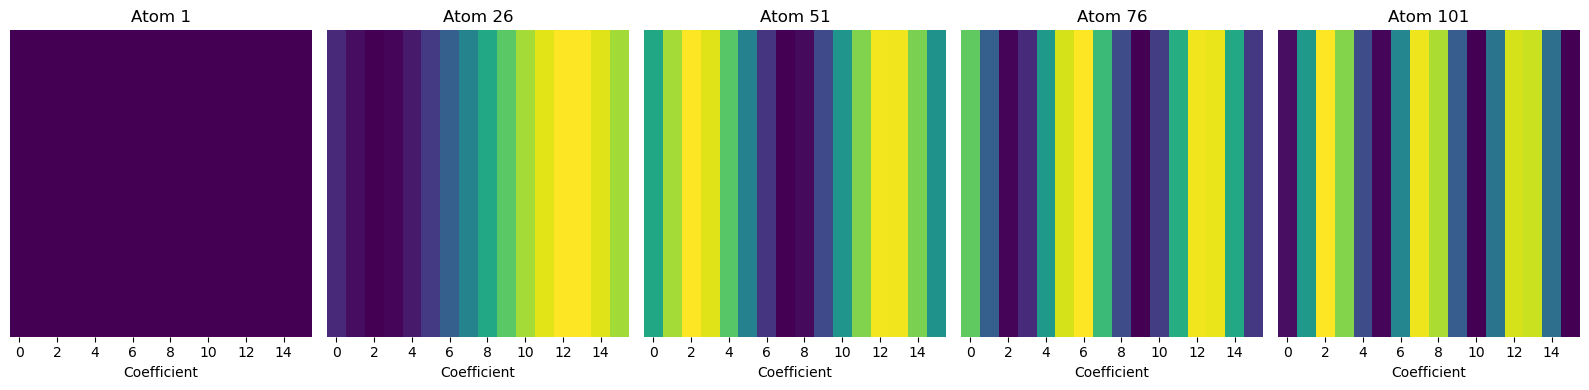

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Example DCT matrix generator (you can use your own)
rows, cols = 16, 128  # Adjust as needed
dct_matrix = DCT1_qt(rows, cols)

# Plotting a few atoms (rows) from the DCT matrix
def plot_dct_atoms(dct_matrix, num_atoms=4):
    fig, axes = plt.subplots(1, num_atoms, figsize=(16, 4))
    columns = dct_matrix.shape[1]
    
    # Calculate step size based on the number of atoms
    step = max(1, columns // num_atoms)
    subplot = 0
    
    for i in range(0, columns, step):
        if subplot >= num_atoms:
            break  # Prevent exceeding the number of subplots
        
        # Select a column (atom) and reshape it for the heatmap
        atom = dct_matrix[:, i].reshape(1, -1)
        sns.heatmap(atom, ax=axes[subplot], cmap="viridis", cbar=False)
        axes[subplot].set_title(f"Atom {i+1}")
        axes[subplot].set_xlabel('Coefficient')
        axes[subplot].set_yticks([])  # Remove the y-ticks for cleaner plot
        subplot += 1
    
    plt.tight_layout()
    plt.show()

# Plot the first 4 atoms (you can specify any number)
plot_dct_atoms(dct_matrix, num_atoms=5)

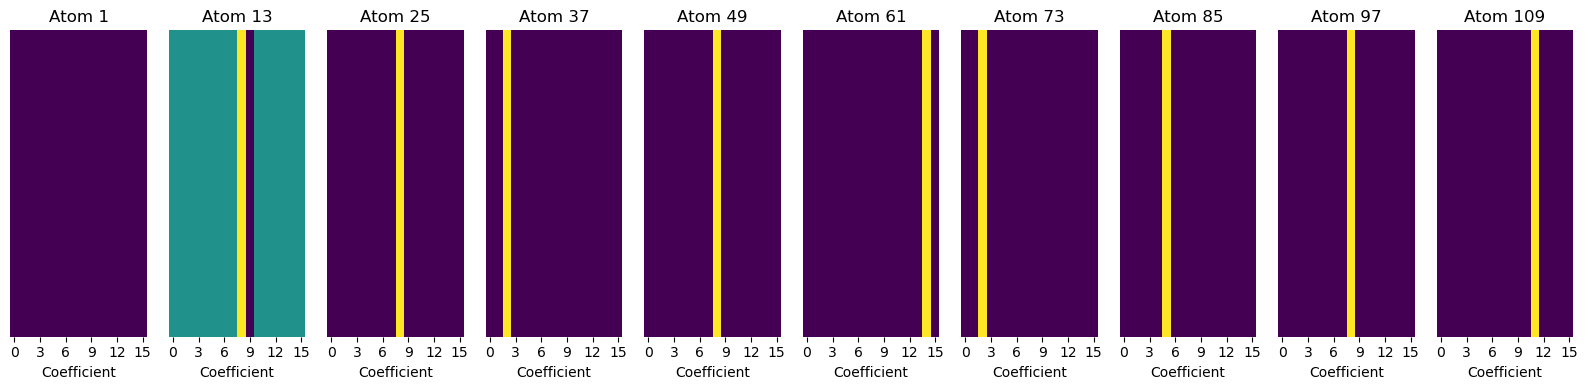

In [123]:
rows, cols = 16, 128  # Adjust as needed
wavelet_matrix = Haar1_qt(rows, cols)
plot_dct_atoms(wavelet_matrix, num_atoms=10)

In [132]:
wavelet_matrix[:,15]

array([ 0.        ,  0.        , -0.02214054,  0.10285946,  0.10285946,
        0.54428109, -1.20571891, -1.20571891,  0.47785946,  0.10285946,
        0.10285946,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ])

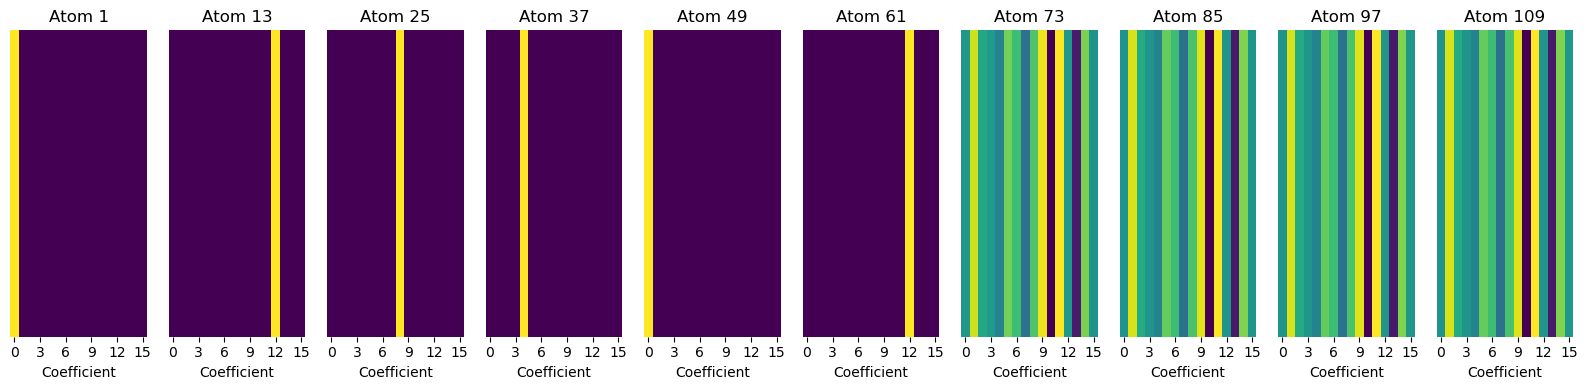

In [40]:
plot_dct_atoms(haar_wavelet_matrix, num_atoms=10)

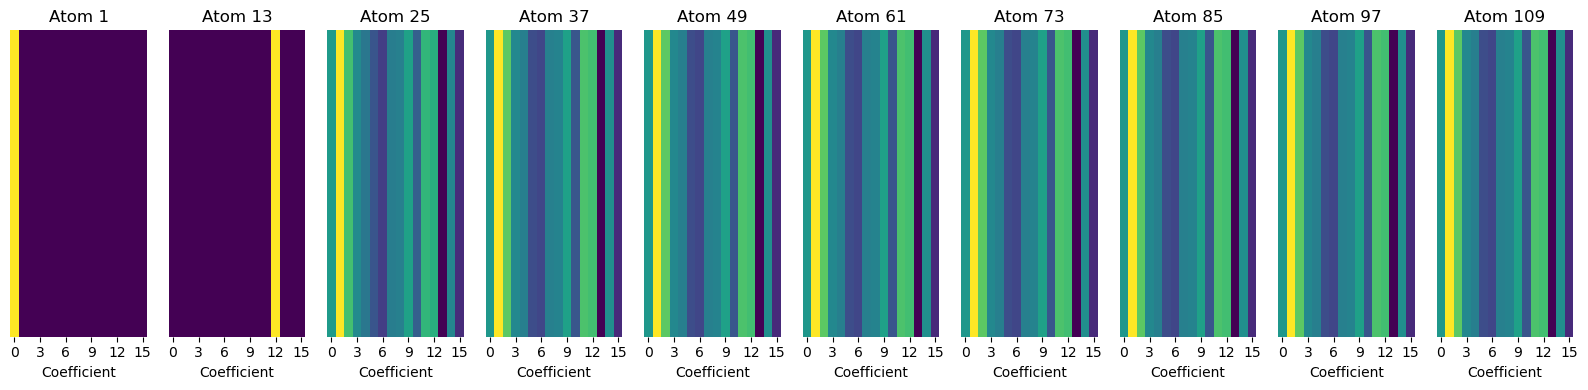

In [41]:
plot_dct_atoms(sym3_wavelet_matrix, num_atoms=10)

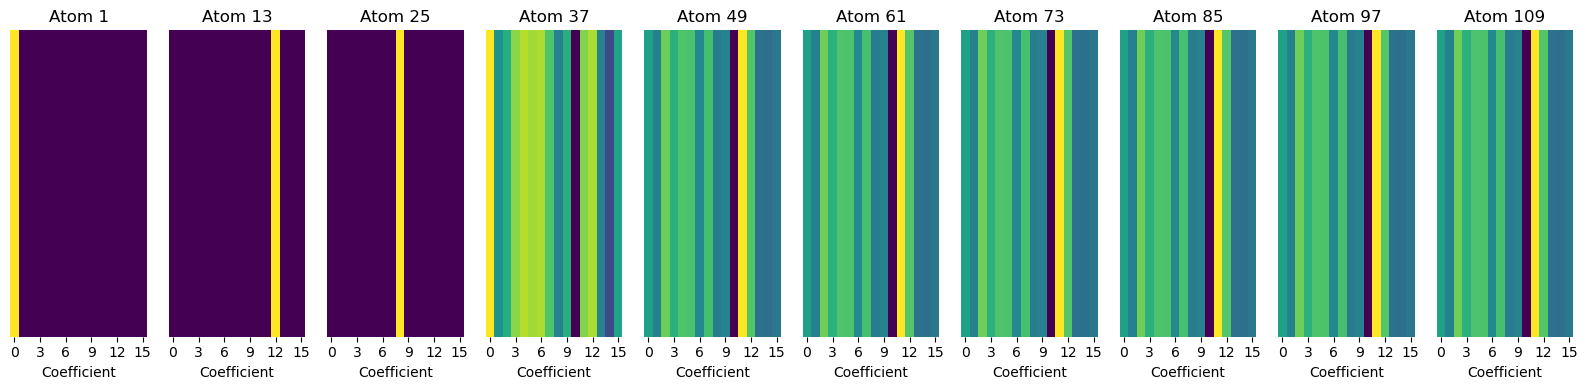

In [42]:
plot_dct_atoms(db2_wavelet_matrix, num_atoms=10)

In [35]:
for i in range(128):
    dot = np.dot(haar_wavelet_matrix[:,i]-np.zeros(16),haar_wavelet_matrix[:,i]-np.zeros(16))
    if dot==0:
        print(i)

64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127


In [76]:
np.dot(wavelet_matrix[:,0],wavelet_matrix[:,0])

1.0000000000000004

In [77]:
wavelet_matrix[:,0]

array([0.25      , 0.25      , 0.35355339, 0.        , 0.5       ,
       0.        , 0.        , 0.        , 0.70710678, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        ])